In [8]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the neural network model
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.to(device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

cpu


In [9]:
# Define the DQN agent class
class DQNAgent:
    # Initialize the DQN agent
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    # Choose an action based on the current state
    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)

    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [10]:
# Initialize the environment and the agent
import gym
from collections import deque
import random

# Set up the environment
env = gym.make("CartPole-v1")

# Define training parameters
num_episodes = 250
max_steps_per_episode = 200
epsilon_start = 1.0
epsilon_end = 0.2
epsilon_decay_rate = 0.99
gamma = 0.9
lr = 0.0025
buffer_size = 10000
buffer = deque(maxlen=buffer_size)
batch_size = 128
update_frequency = 10


# Initialize the DQNAgent
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
new_agent = DQNAgent(input_dim, output_dim, seed=170715, lr = lr)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [11]:
# Training loop
for episode in range(num_episodes):
    # Reset the environment
    state = env.reset()
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay_rate ** episode))

    # Run one episode
    for step in range(max_steps_per_episode):
        # Choose and perform an action
        action = new_agent.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        buffer.append((state, action, reward, next_state, done))

        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            # Update the agent's knowledge
            new_agent.learn(batch, gamma)

        state = next_state

        # Check if the episode has ended
        if done:
            break

    if (episode + 1) % update_frequency == 0:
        print(f"Episode {episode + 1}: Finished training")

Episode 10: Finished training
Episode 20: Finished training
Episode 30: Finished training
Episode 40: Finished training
Episode 50: Finished training
Episode 60: Finished training
Episode 70: Finished training
Episode 80: Finished training
Episode 90: Finished training
Episode 100: Finished training
Episode 110: Finished training
Episode 120: Finished training
Episode 130: Finished training
Episode 140: Finished training
Episode 150: Finished training
Episode 160: Finished training
Episode 170: Finished training
Episode 180: Finished training
Episode 190: Finished training
Episode 200: Finished training
Episode 210: Finished training
Episode 220: Finished training
Episode 230: Finished training
Episode 240: Finished training
Episode 250: Finished training


In [12]:
# Evaluate the agent's performance
test_episodes = 100
episode_rewards = []

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = new_agent.act(state, eps=0.)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

    episode_rewards.append(episode_reward)

average_reward = sum(episode_rewards) / test_episodes
print(f"Average reward over {test_episodes} test episodes: {average_reward:.2f}")


Average reward over 100 test episodes: 257.62


In [13]:
# Visualize the agent's performance
import time

state = env.reset()
done = False

while not done:
    env.render()
    action = new_agent.act(state, eps=0.)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    time.sleep(0.1)  # Add a delay to make the visualization easier to follow

env.close()

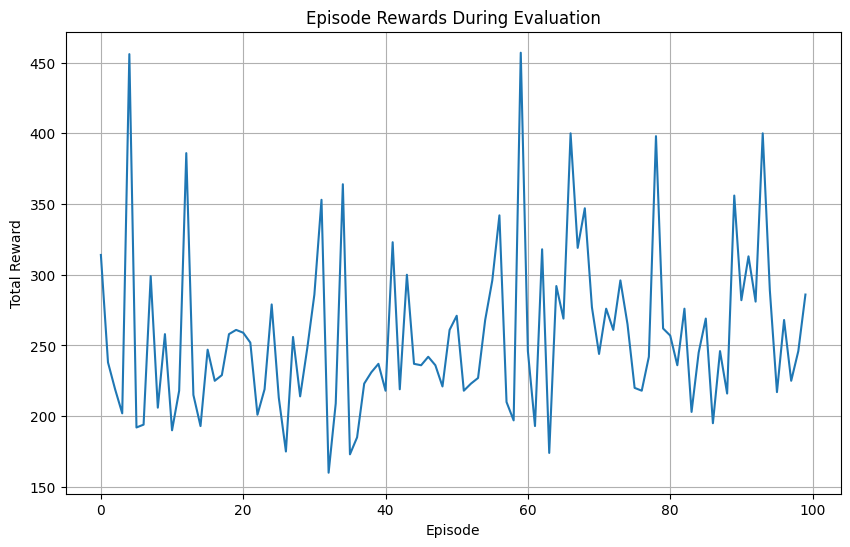

In [15]:
import matplotlib.pyplot as plt

# Plot the episode rewards
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Rewards During Evaluation")
plt.grid(True)
plt.show()